In [1]:
!pip install tensorflow   # Install TensorFlow if not already installed
!pip install scikit-learn  # Install scikit-learn if not already installed
!pip install tqdm  # Install tqdm for progress bars if not already installed

import os
from pathlib import Path
import numpy as np
import random
from PIL import Image
from tqdm.notebook import tqdm
from tqdm import tqdm

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Set seed
SEED = 42   # Random seed for reproducibility
random.seed(SEED)     # Set random seed for reproducibility
np.random.seed(SEED)    # Set NumPy seed for reproducibility
tf.random.set_seed(SEED)    # Set TensorFlow seed for reproducibility

# Paths
TRAIN_PATH = Path("/kaggle/input/sunnycomsys-new/Comys_Hackathon5/Task_B/train")    # Path to training images	Local-directory->E:/comsys_2025/Comys_Hackathon5/Task_B/train
VAL_PATH   = Path("/kaggle/input/sunnycomsys-new/Comys_Hackathon5/Task_B/val")    # Path to validation images local directory->E:/comsys_2025/Comys_Hackathon5/Task_B/train

# Image constants
IMG_SIZE = (100, 100)   # Size to which images will be resized
INPUT_SHAPE = IMG_SIZE + (1,)   # Input shape for the model (grayscale images)


2025-06-30 03:57:45.972457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751255866.201045      34 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751255866.264116      34 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.listdir("/kaggle/input/sunnycomsys-new/Comys_Hackathon5/Task_B")

['val', 'train']

# Helper Functions for Loading Images & Preprocessing

In [3]:
def load_image(path):                                                                                           # Load and preprocess an image
    """Load an image from the given path, convert to grayscale, resize, and normalize."""
    img = Image.open(path).convert("L")  # Grayscale
    img = img.resize(IMG_SIZE)
    img = np.array(img, dtype=np.float32) / 255.0
    return img.reshape(INPUT_SHAPE)

def get_image_pairs(data_path):                                                                                 # Generate image pairs and labels
    """Generate pairs of images and their labels from the dataset."""
    persons = list(data_path.iterdir())
    pairs = []
    labels = []

    for person in tqdm(persons):
        if not person.is_dir():
            continue

        # Get the clean image (only file directly inside the person folder)
        clean_imgs = [f for f in person.iterdir() if f.is_file() and f.suffix.lower() == ".jpg"]
        if len(clean_imgs) == 0:
            continue
        clean_img = load_image(clean_imgs[0])  # there's only one

        # Check if distortion folder exists
        distortion_folder = person / "distortion"
        if not distortion_folder.exists():
            continue

        distorted_imgs = list(distortion_folder.glob("*.jpg"))
        if len(distorted_imgs) == 0:
            continue

        # Positive pairs
        for d_img in distorted_imgs:
            distorted_img = load_image(d_img)
            pairs.append((clean_img, distorted_img))
            labels.append(1)

            # Negative pair: pick distorted img from a different person
            other_candidates = [p for p in persons if p != person and (p / "distortion").exists()]
            if not other_candidates:
                continue
            other = random.choice(other_candidates)
            other_distorted_imgs = list((other / "distortion").glob("*.jpg"))
            if not other_distorted_imgs:
                continue
            neg_img = load_image(random.choice(other_distorted_imgs))
            pairs.append((clean_img, neg_img))
            labels.append(0)

        

    print(f"✅ Generated {len(pairs)} image pairs.")
    X1 = np.array([x[0] for x in pairs])
    X2 = np.array([x[1] for x in pairs])
    y = np.array(labels)
    return X1, X2, y





# Siamese Network Model

In [4]:
def build_embedding_model(input_shape):                                                                    # Build the embedding model    
    """Build a simple CNN model for embedding images."""
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64)
    ])
    return model

def build_siamese_model(input_shape):                                                               # Build the Siamese model
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    base_model = build_embedding_model(input_shape)

    emb_a = base_model(input_a)
    emb_b = base_model(input_b)

    L1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([emb_a, emb_b])
    output = Dense(1, activation="sigmoid")(L1_distance)

    model = Model(inputs=[input_a, input_b], outputs=output)
    model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
    return model, base_model


# Train the Model

In [5]:
X1, X2, y = get_image_pairs(TRAIN_PATH)                                     # Load image pairs and labels from the training dataset
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=SEED)  # Note: the validation set used here is part of the training dataset, not a separate validation set
                                                                            # Build and compile the Siamese model
                                                                            # Note: The model is compiled with binary crossentropy loss and Adam optimizer
siamese_model, embedding_model = build_siamese_model(INPUT_SHAPE)   
siamese_model.summary() 

siamese_model.fit([X1_train, X2_train], y_train,                           # Train the Siamese model
                  validation_data=([X1_val, X2_val], y_val),
                  batch_size=32, epochs=60)                                # 60 epochs for better performance


100%|██████████| 877/877 [07:30<00:00,  1.95it/s] 


✅ Generated 26964 image pairs.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751256332.304608      34 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100, 100, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64)             │      8,750,016 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 64)             │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,750,081 (33.38 MB)

 Trainable params: 8,750,081 (33.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1751256340.082479     108 service.cc:148] XLA service 0x7e1f500039b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751256340.083272     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751256340.461015     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/675 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5784 - loss: 0.6910

I0000 00:00:1751256343.026627     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6567 - loss: 0.6217 - val_accuracy: 0.7647 - val_loss: 0.5032
Epoch 2/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7795 - loss: 0.4711 - val_accuracy: 0.8131 - val_loss: 0.4143
Epoch 3/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8435 - loss: 0.3619 - val_accuracy: 0.8526 - val_loss: 0.3409
Epoch 4/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8883 - loss: 0.2764 - val_accuracy: 0.8769 - val_loss: 0.2924
Epoch 5/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9267 - loss: 0.2006 - val_accuracy: 0.8889 - val_loss: 0.2847
Epoch 6/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9486 - loss: 0.1460 - val_accuracy: 0.9006 - val_loss: 0.2686
Epoch 7/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9608 - loss: 0.1136 - val_accuracy: 0.9116 - val_loss: 0.2357
Epoch 8/60
675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9692 - loss: 0.0902 - val_accurac

# Verification on VAL_PATH

Computing distances: 100%|██████████| 5908/5908 [13:47<00:00,  7.14it/s]


🔍 Best threshold based on ROC: 124.09020233154297


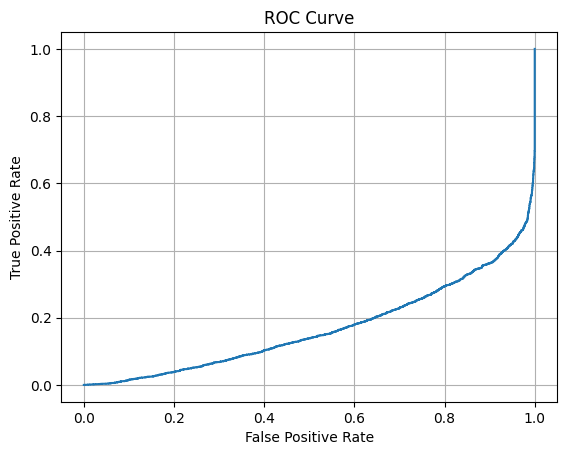

In [12]:
# === Generate Validation Pairs ===
X1_val, X2_val, y_val = [], [], []
persons = [p for p in VAL_PATH.iterdir() if p.is_dir()]

for person in tqdm(persons, desc="Generating validation pairs"):
    clean_imgs = list(person.glob("*.jpg"))
    distorted_imgs = list((person / "distortion").glob("*.jpg"))

    if not clean_imgs or not distorted_imgs:
        continue

    clean = load_image(clean_imgs[0])

    for d_img in distorted_imgs:
        distorted = load_image(d_img)
        
        # Positive pair
        X1_val.append(clean)
        X2_val.append(distorted)
        y_val.append(1)

        # Negative pair with another identity
        other = random.choice([p for p in persons if p != person and (p / "distortion").exists()])
        neg_img = random.choice(list((other / "distortion").glob("*.jpg")))
        neg = load_image(neg_img)

        X1_val.append(clean)
        X2_val.append(neg)
        y_val.append(0)

# === Get Distances ===
distances = []
true_labels = []

for i in tqdm(range(len(X1_val)), desc="Computing distances"):
    emb1 = embedding_model.predict(np.expand_dims(X1_val[i], axis=0), verbose=0)[0]
    emb2 = embedding_model.predict(np.expand_dims(X2_val[i], axis=0), verbose=0)[0]
    dist = np.linalg.norm(emb1 - emb2)

    distances.append(dist)
    true_labels.append(y_val[i])

# === Compute ROC Curve and Best Threshold ===
fpr, tpr, thresholds = roc_curve(true_labels, distances, pos_label=1)
best_threshold = thresholds[np.argmax(tpr - fpr)]

print(f"🔍 Best threshold based on ROC: {round(best_threshold, 4)}")

# Optional: Plot ROC Curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()

# saving the MODEL

In [18]:
# Save entire Siamese model
siamese_model.save("kaggle/working/taskb_siamese.h5")                          # .keras format can also be used
embedding_model.save("kaggle/working/taskb_siamese_embedding.h5")
print("Models saved successfully.")

Models saved successfully.


In [2]:
from tensorflow.keras.models import load_model
model=load_model("taskb_siamese_embedding.h5")
for layer in model.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    for w in weights:
        print(w.shape)
        print(w)

Layer: conv2d
(3, 3, 1, 64)
[[[[-0.08385536 -0.05524066  0.10728586 -0.09772648 -0.15072459
     0.02943529 -0.23646313 -0.0985064  -0.15990944 -0.03585535
     0.07638825 -0.3006706  -0.14923835 -0.00542185 -0.06209597
    -0.00611622  0.17126842 -0.11646885 -0.17332485 -0.00330459
    -0.07681967 -0.07296968  0.03356909 -0.24368513 -0.11416937
    -0.0808584  -0.07305178 -0.2455894  -0.03310214  0.00275942
    -0.4377574   0.0336266   0.00729439  0.316697    0.2810848
     0.01429451  0.09526608 -0.25388724  0.40259025 -0.01999436
    -0.00944189  0.08511536 -0.08982063 -0.07245841  0.17762826
    -0.21883725  0.07026362 -0.19071518  0.24330512 -0.40449592
    -0.328421   -0.10264971 -0.37275407 -0.17647566 -0.03825893
     0.02769739 -0.03750281 -0.0115594   0.08114383 -0.05044762
    -0.04298749 -0.00338962 -0.45007494  0.01849357]]

  [[-0.15730602 -0.14078343 -0.05593614 -0.08642931 -0.14093725
    -0.2311727  -0.18059595  0.10110488  0.10381629 -0.07126913
    -0.02386079  0.080